# First evaluation insights
So far just copied from eval.py but meant to be used for more strucutred plotting and analysis.

In [21]:
%matplotlib inline
import glob
import yaml
import matplotlib.pyplot as plt

In [22]:
def process_emu_results(prefix=''):
    emu_results = glob.glob('emulation/{}*.yaml'.format(prefix))
    emu_delays = []
    for result_file in emu_results:
        with open(result_file, 'r') as f:
            result = yaml.load(f)

            # chain delays = httping = TCP handshake = 2x RTT
            result['chain_rtt'] = result['chain_delay']['delay'] / 2

            # vnf delays = ping = RTT
            for delay in result['delays']:
                delay['rtt'] = delay['delay']

            emu_delays.append(result)
    return emu_delays

In [23]:
def process_sim_results(prefix=''):
    sim_results = glob.glob('bjointsp/{}*.yaml'.format(prefix))
    sim_delays = []
    for result_file in sim_results:
        with open(result_file, 'r') as f:
            result = yaml.load(f)

            # TODO: extract chain length, num flows...? or better write to file
            # chain_length = int(result['input']['service'][2]) + 2        # +2 for user and web

            # one-way = RTT/2
            result['chain_rtt'] = result['metrics']['total_delay'] * 2
            for delay in result['metrics']['delays']:
                delay['rtt'] = delay['delay'] * 2

            sim_delays.append(result)
    return sim_delays

In [24]:
prefix = 'Airtel'
emu_delays = process_emu_results(prefix)
sim_delays = process_sim_results(prefix)

Airtel is a medium-large network with nodes far away from each other. This leads to high link delays and lower impact of rounding link delays to full integers, which was a problem with the very dense Colt network.

In [25]:
# TODO: very hacky and inefficient. what's a more elegant way?
# match and sort chain and inter-VNF RTTs
emu_chain_rtt, sim_chain_rtt = [], []
emu_vnf_rtt, sim_vnf_rtt = [], []
for emu in emu_delays:
    for sim in sim_delays:
        # match chain delays (same input: network, service, sources)
        if emu['input']['network'].endswith(sim['input']['network']) \
                and emu['input']['service'].endswith(sim['input']['service']) \
                and emu['input']['sources'].endswith(sim['input']['sources']):
            emu_chain_rtt.append(emu['chain_rtt'])
            sim_chain_rtt.append(sim['chain_rtt'])

            # match inter-VNF RTTs (same input + src, dest)
            for emu_vnf in emu['delays']:
                for sim_vnf in sim['metrics']['delays']:
                    if emu_vnf['src'] == sim_vnf['src'] and emu_vnf['dest'] == sim_vnf['dest']:
                        emu_vnf_rtt.append(emu_vnf['rtt'])
                        sim_vnf_rtt.append(sim_vnf['rtt'])

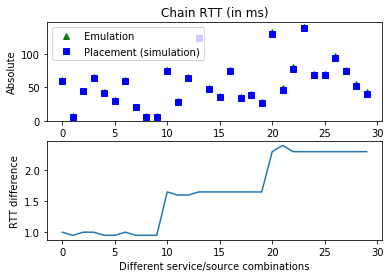

In [26]:
# 1.1 chain delays
x_chain = range(len(emu_delays))
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(x_chain, emu_chain_rtt, 'g^', x_chain, sim_chain_rtt, 'bs')
# plt.xticks(x_chain, sim_chain_length)
plt.legend(['Emulation', 'Placement (simulation)'])
plt.ylabel('Absolute')
plt.title('Chain RTT (in ms)')

# 1.2 chain delay difference emu - sim
chain_diffs = [emu_chain_rtt[i]-sim_chain_rtt[i] for i in range(len(emu_chain_rtt))]
plt.subplot(2, 1, 2)
plt.plot(x_chain, chain_diffs)
# plt.xticks(x_chain, sim_chain_length)
plt.xlabel('Different service/source combinations')
plt.ylabel('RTT difference')

# FIXME: saving doesn't seem to work
plt.savefig('plots/{}-chainRtt.pdf'.format(prefix), bbox_inches='tight') 
plt.show()

Again, also for Airtel, there are clear steps at 10, 20, showing the impact of different chain lengths (10x fw1, 10x fw2, 10x fw3). TODO: Directly show chain lengths.

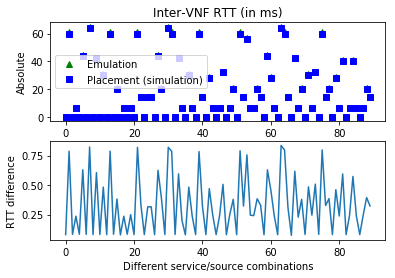

In [27]:
# 2.1 inter-VNF delays
x_vnfs = range(len(emu_vnf_rtt))
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(x_vnfs, emu_vnf_rtt, 'g^', x_vnfs, sim_vnf_rtt, 'bs')
# plt.errorbar(x_vnfs, emu_vnf_rtt, yerr=emu_vnf_std, fmt='none', ecolor='black', capsize=2)
# plt.xticks(x_vnfs, sim_vnf_length)
plt.legend(['Emulation', 'Placement (simulation)'])
plt.ylabel('Absolute')
plt.title('Inter-VNF RTT (in ms)')

# 2.2 inter-VNF delay difference: emu - sim
vnf_diffs = [emu_vnf_rtt[i]-sim_vnf_rtt[i] for i in range(len(emu_vnf_rtt))]
plt.subplot(2, 1, 2)
plt.plot(x_vnfs, vnf_diffs)
# plt.xticks(x_vnfs, sim_vnf_length)
plt.xlabel('Different service/source combinations')
plt.ylabel('RTT difference')

plt.savefig('plots/{}-vnfRtt.pdf'.format(prefix), bbox_inches='tight')
plt.show()